# Lightricks Challenge - DataHack 2018

In [195]:
import os
import sys
import operator
import numpy as np
import pandas as pd
import scipy
import dateutil
from sklearn.model_selection import train_test_split,KFold,cross_val_score
# from sklearn.cross_validation import train_test_split, KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

In [196]:
%matplotlib inline
import seaborn as sns
sns.set()

In [197]:
path = './'
teamname = 'MadeInJerusalem'
out_name = path + teamname + '_submission.csv'

In [198]:
df_usage = pd.read_csv(path + "train_usage_data.csv")

In [199]:
#Looking data format and types
df_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263814 entries, 0 to 263813
Data columns (total 5 columns):
id                263814 non-null int64
feature_name      263814 non-null object
usage_duration    263814 non-null float64
end_use_date      263814 non-null object
accepted          263814 non-null bool
dtypes: bool(1), float64(1), int64(1), object(2)
memory usage: 8.3+ MB


The variables in dataframe "df_usage" are:

| Field name   | Description | 
|----------|-------------|
| id | User ID |
| feature_name | Name of feature used |
| usage_duration | Duration in seconds between feature was entered and accepted or canceled |
| use_date | Date and time when the feature was entered |
| accepted | True if the user accepted the changes by the feature and False if he did not accepted the changes |

In [200]:
df_usage.head()

,id,feature_name,usage_duration,end_use_date,accepted
0,30000429392689,Relight,5.659,2018-04-10 11:18:16,False
1,440000407817536,Crop,0.984,2018-04-06 16:44:19,False
2,540000265662400,Crop,1.583,2018-04-21 18:46:24,False
3,220000444951653,Vignette,4.668,2018-04-30 14:11:22,False
4,220000444725338,Retouch,185.154,2018-04-29 23:37:34,False


In [201]:
df_users = pd.read_csv(path + "train_users_data.csv",parse_dates = [ 'installation_date','subscripiton_date'])

In [202]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6998 entries, 0 to 6997
Data columns (total 10 columns):
Unnamed: 0             6998 non-null int64
id                     6998 non-null int64
installation_date      6998 non-null datetime64[ns]
subscripiton_date      6998 non-null datetime64[ns]
country                6996 non-null object
initial_app_version    6998 non-null object
initial_ios_version    6998 non-null object
initial_device         6998 non-null object
days_until_churn       3220 non-null float64
churned                6998 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(3), object(4)
memory usage: 546.8+ KB


In [203]:
df_users.head()

,Unnamed: 0,id,installation_date,subscripiton_date,country,initial_app_version,initial_ios_version,initial_device,days_until_churn,churned
0,1,100000415577994,2017-07-16 22:29:31,2018-04-01 01:35:58,Canada,1.9.1,11.2.5,UIDeviceKindIPhoneX,NaN,0
1,2,100000415580508,2016-12-19 14:28:03,2018-04-01 01:45:40,New Zealand,1.7.5,11.2.1,UIDeviceKindIPhoneX,136.0,0
2,3,100000415636784,2017-02-09 00:48:33,2018-04-01 05:15:46,United States,1.6,10.3.3,UIDeviceKindIPhone6S,70.0,0
3,4,100000415750897,2017-12-07 16:03:47,2018-04-01 13:27:22,Turkey,1.9.5,11.2.6,UIDeviceKindIPhone5S,NaN,0
4,5,100000415825030,2017-12-01 14:59:29,2018-04-01 17:23:33,United States,1.9.5,11.2.6,UIDeviceKindIPhone8,9.0,1


The variables in dataframe "df_users" are:

| Field name   | Description | 
|----------|-------------|
| id | User ID |
| installation_date | Date and time when the application was first installed |
| subscription_date | Date and time when the user joined as a subscriber |
| country | Country where the user is based |
| days_until_churned | Days before the user decided to leave the subscription (churn). NaN if the user has not churned |
| churned | False if the user is still a subscriber and True if the user stopped his subscription. |

In [204]:
df_users = df_users.drop(columns='Unnamed: 0')
df_users.head()

,id,installation_date,subscripiton_date,country,initial_app_version,initial_ios_version,initial_device,days_until_churn,churned
0,100000415577994,2017-07-16 22:29:31,2018-04-01 01:35:58,Canada,1.9.1,11.2.5,UIDeviceKindIPhoneX,NaN,0
1,100000415580508,2016-12-19 14:28:03,2018-04-01 01:45:40,New Zealand,1.7.5,11.2.1,UIDeviceKindIPhoneX,136.0,0
2,100000415636784,2017-02-09 00:48:33,2018-04-01 05:15:46,United States,1.6,10.3.3,UIDeviceKindIPhone6S,70.0,0
3,100000415750897,2017-12-07 16:03:47,2018-04-01 13:27:22,Turkey,1.9.5,11.2.6,UIDeviceKindIPhone5S,NaN,0
4,100000415825030,2017-12-01 14:59:29,2018-04-01 17:23:33,United States,1.9.5,11.2.6,UIDeviceKindIPhone8,9.0,1


# Data exploration:

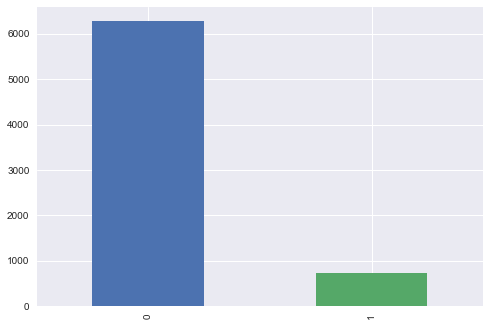

In [205]:
df_users['churned'].value_counts().plot('bar')

In [206]:
joined_df = df_usage.join(df_users.set_index('id'),on='id')

In [207]:
joined_df.head()

,id,feature_name,usage_duration,end_use_date,accepted,installation_date,subscripiton_date,country,initial_app_version,initial_ios_version,initial_device,days_until_churn,churned
0,30000429392689,Relight,5.659,2018-04-10 11:18:16,False,2018-02-26 07:01:08,2018-04-08 09:38:19,Australia,1.9.6,11.2.6,UIDeviceKindIPhoneX,NaN,0
1,440000407817536,Crop,0.984,2018-04-06 16:44:19,False,2017-07-21 20:04:15,2018-04-05 22:39:32,United Kingdom,1.9.6,11.2.5,UIDeviceKindIPhoneX,NaN,0
2,540000265662400,Crop,1.583,2018-04-21 18:46:24,False,2018-04-21 02:01:23,2018-04-21 02:14:14,United States,1.9.6,11.2,UIDeviceKindIPhone8,NaN,0
3,220000444951653,Vignette,4.668,2018-04-30 14:11:22,False,2018-04-30 12:45:44,2018-04-30 12:57:44,Australia,1.9.6,11.2.5,UIDeviceKindIPhone7Plus,NaN,0
4,220000444725338,Retouch,185.154,2018-04-29 23:37:34,False,2018-04-29 21:14:23,2018-04-29 22:07:56,United States,1.9.6,11.2.6,UIDeviceKindIPhone6Plus,31.0,0


In [208]:
joined_df.usage_duration.to_frame().head()

,usage_duration
0,5.659
1,0.984
2,1.583
3,4.668
4,185.154


In [209]:
total_number_of_usage_per_feature = df_usage['feature_name'].value_counts()
total_number_of_usage_per_feature.shape

(17,)

In [210]:
k = 10
top_k_features_churned = joined_df[joined_df['churned']==True]['feature_name'].value_counts().index[:k]
top_k_features_not_churned = joined_df[joined_df['churned']==False]['feature_name'].value_counts().index[:k]

In [211]:
top_k_features_not_churned

Index(['Vignette', 'Light FX', 'Crop', 'Retouch', 'Darkroom', 'Touch Up',
       'Prism', 'Filters', 'Adjust', 'Paint'],
      dtype='object')

In [212]:
df_churned = joined_df[(joined_df['churned']==True) & (joined_df['accepted']==True)]
df_churned.head()

,id,feature_name,usage_duration,end_use_date,accepted,installation_date,subscripiton_date,country,initial_app_version,initial_ios_version,initial_device,days_until_churn,churned
11257,720000252018353,Light FX,60.660,2018-04-30 04:29:32,True,2017-09-03 02:05:27,2018-04-30 02:02:01,United States,1.9.6,11.3,UIDeviceKindIPhone7,23.0,1
11259,600000282080576,Vignette,24.301,2018-04-07 00:15:17,True,2017-04-03 23:18:27,2018-04-06 23:50:54,United States,1.3.1,9.2.1,UIDeviceKindIPhone6S,8.0,1
11266,710000287544169,Light FX,52.603,2018-04-16 04:00:36,True,2018-04-16 00:56:59,2018-04-16 01:02:31,India,1.9.6,11.3,UIDeviceKindIPhone6,11.0,1
11283,160000445692440,Filters,15.174,2018-04-06 18:06:13,True,2018-02-11 16:12:36,2018-04-06 18:04:41,United States,1.9.3,11.2.6,UIDeviceKindIPhone8Plus,25.0,1
11427,160000445692440,Filters,6.258,2018-04-06 18:08:02,True,2018-02-11 16:12:36,2018-04-06 18:04:41,United States,1.9.3,11.2.6,UIDeviceKindIPhone8Plus,25.0,1


C:\Programs\Anaconda\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


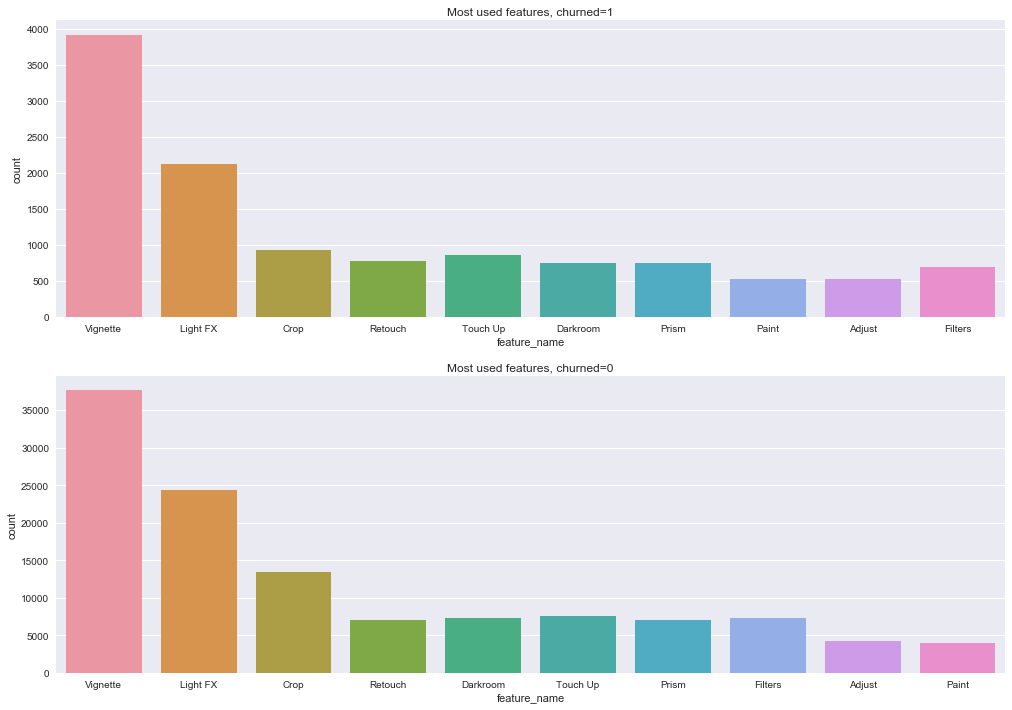

In [213]:
#What are the most popular features, within each class:

#total_number_of_usage_per_feature = df_usage['feature_name'].value_counts()



# k = 10
# top_k_features_churned = joined_df[joined_df['churned']==True]['feature_name'].value_counts().index[:k]
# top_k_features_not_churned = joined_df[joined_df['churned']==False]['feature_name'].value_counts().index[:k]


fig, ax = plt.subplots(2,1, figsize=(17,12))
df_churned = joined_df[(joined_df['churned']==True) & (joined_df['accepted']==True)]
p = sns.countplot(data=df_churned[df_churned['feature_name'].isin(top_k_features_churned)], x='feature_name', order = top_k_features_churned, ax=ax[0])

df_not_churned = joined_df[(joined_df['churned']==False) & (joined_df['accepted']==True)]
q = sns.countplot(data=df_not_churned[df_not_churned['feature_name'].isin(top_k_features_not_churned)], x='feature_name', order = top_k_features_not_churned, ax=ax[1])

ax[0].set_title('Most used features, churned=1')
ax[1].set_title('Most used features, churned=0')

In [214]:
groupedDf = joined_df.groupby(['id', 'churned', 'feature_name'])
groupedDf.mean().head()

usage_duration  accepted  \
id             churned feature_name                             
20000443246052 0       Adjust             50.352000  0.000000   
                       Crop               17.437571  0.571429   
                       Darkroom           19.860500  0.500000   
                       Defocus            14.732000  1.000000   
                       Eyes                4.765000  1.000000   

                                     days_until_churn  
id             churned feature_name                    
20000443246052 0       Adjust                     NaN  
                       Crop                       NaN  
                       Darkroom                   NaN  
                       Defocus                    NaN  
                       Eyes                       NaN

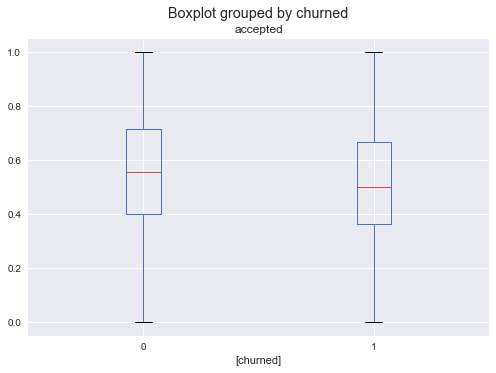

In [215]:
joined_df.groupby(['id', 'churned'])[['accepted']].mean().boxplot(by='churned')

# TODO: Filter outliers

In [216]:
#end_of_time_series = np.log(joined_df['usage_duration']).hist()
joined_df = joined_df[joined_df['usage_duration']<200]

# Creating our input data:

In [217]:
app_ver_map = joined_df.groupby(['initial_app_version'])['churned'].mean()
ios_ver_map = joined_df.groupby(['initial_ios_version'])['churned'].mean()
device_map = joined_df.groupby(['initial_device'])['churned'].mean()
country_map = joined_df.groupby(['country'])['churned'].mean()

In [291]:
app_ver = joined_df.groupby(['id'])['initial_app_version'].first().to_frame()
app_ver.head()

,initial_app_version
id,
20000443246052,1.9.5
20000443252617,1.7.5
20000443310150,1.9.5
20000443405819,1.9.5
20000443434193,1.9.5


In [293]:
# Add time statistics
def create_features(joined_df):
    start_of_time_series = joined_df['subscripiton_date'].min()
    print(start_of_time_series)
    end_of_time_series = joined_df['end_use_date'].max()
    print(end_of_time_series)
    date_features = joined_df[['id','installation_date','subscripiton_date','end_use_date']].groupby('id').max()
    date_features['days_installed'] = (pd.to_datetime(end_of_time_series) - date_features['installation_date']).dt.days
    date_features['days_installed_not_subscribed'] = (date_features['subscripiton_date'] - date_features['installation_date']).dt.days
    date_features['days_since_last_use'] = (pd.to_datetime(end_of_time_series) - pd.to_datetime(date_features['end_use_date'])).dt.days
    date_features['days_used'] = np.minimum((pd.to_datetime(date_features['end_use_date']) - date_features['installation_date']).dt.days, 
                                            (pd.to_datetime(date_features['end_use_date']) - pd.to_datetime(start_of_time_series) ).dt.days)
    date_features = date_features[['days_installed','days_installed_not_subscribed','days_since_last_use','days_used']]
    
    users_mean_usage_time = pd.pivot_table(joined_df[['id', 'feature_name', 'usage_duration']], values='usage_duration', index=['id'], columns=['feature_name'], aggfunc=np.mean, fill_value=0)
    users_mean_usage_time = users_mean_usage_time.add_suffix('_mean_time')
    
    users_mean_acceptance_rate = pd.pivot_table(joined_df[['id', 'feature_name', 'accepted']], values='accepted', index=['id'], columns=['feature_name'], aggfunc=np.mean, fill_value=0)
    users_mean_acceptance_rate = users_mean_acceptance_rate.add_suffix('_mean_acceptance')
    
    users_usage_summaries = pd.pivot_table(joined_df[['id', 'feature_name']], index=['id'], columns=['feature_name'], aggfunc=len, fill_value=0)
    
    accepted_rate = joined_df.groupby(['id'])['accepted'].mean().to_frame()
    
    app_ver = joined_df.groupby(['id'])['initial_app_version'].first().to_frame()
#     app_ver = joined_df.replace({'initial_app_version':app_ver_map}).groupby(['id'])['initial_app_version'].mean().to_frame()
    ios_ver = joined_df.groupby(['id'])['initial_ios_version'].first().to_frame()
#     ios_ver = joined_df.replace({'initial_ios_version':ios_ver_map}).groupby(['id'])['initial_ios_version'].mean().to_frame()
    
    device = joined_df.groupby(['id'])['initial_device'].first().to_frame()
#     device = joined_df.replace({'initial_device':device_map}).groupby(['id'])['initial_device'].mean().to_frame()
    
    country = joined_df.groupby(['id'])['country'].first().to_frame()
#     country = joined_df.replace({'country':country_map}).groupby(['id'])['country'].mean().to_frame()
    
    total_features = users_usage_summaries.join(users_mean_usage_time, how='left').join(users_mean_acceptance_rate, how='left').join(date_features, how='left').join(accepted_rate, how='left').join(country, how='left').join(device, how='left').join(ios_ver, how='left').join(app_ver, how='left')
    total_features.fillna(0)
    #This is how our df looks like:
    print(total_features.shape)
    total_features.head()
    return total_features

In [244]:
joined_df.head()

,id,feature_name,usage_duration,end_use_date,accepted,installation_date,subscripiton_date,country,initial_app_version,initial_ios_version,initial_device,days_until_churn,churned
0,30000429392689,Relight,5.659,2018-04-10 11:18:16,False,2018-02-26 07:01:08,2018-04-08 09:38:19,Australia,1.9.6,11.2.6,UIDeviceKindIPhoneX,NaN,0
1,440000407817536,Crop,0.984,2018-04-06 16:44:19,False,2017-07-21 20:04:15,2018-04-05 22:39:32,United Kingdom,1.9.6,11.2.5,UIDeviceKindIPhoneX,NaN,0
2,540000265662400,Crop,1.583,2018-04-21 18:46:24,False,2018-04-21 02:01:23,2018-04-21 02:14:14,United States,1.9.6,11.2,UIDeviceKindIPhone8,NaN,0
3,220000444951653,Vignette,4.668,2018-04-30 14:11:22,False,2018-04-30 12:45:44,2018-04-30 12:57:44,Australia,1.9.6,11.2.5,UIDeviceKindIPhone7Plus,NaN,0
4,220000444725338,Retouch,185.154,2018-04-29 23:37:34,False,2018-04-29 21:14:23,2018-04-29 22:07:56,United States,1.9.6,11.2.6,UIDeviceKindIPhone6Plus,31.0,0


In [329]:
# train data features
total_features = create_features(joined_df)
churned = joined_df.groupby(['id'])['churned'].mean().to_frame()
total_features = total_features.join(churned, how='left')
print(total_features.shape)
total_features.head()

2018-04-01 00:02:30
2018-05-07 22:02:00
(6918, 60)
(6918, 61)


,Adjust,Backdrop,Crop,Darkroom,Defocus,Eyes,Face,Filters,Light FX,Paint,...,days_installed,days_installed_not_subscribed,days_since_last_use,days_used,accepted,country,initial_device,initial_ios_version,initial_app_version,churned
id,,,,,,,,,,,,,,,,,,,,,
20000443246052,1,0,14,2,1,1,0,0,17,6,...,159,123,30,6,0.590909,Brazil,UIDeviceKindIPhone6S,11.2.6,1.9.5,0
20000443252617,2,2,0,7,0,0,0,0,16,1,...,474,438,30,6,0.409836,United States,UIDeviceKindIPhone6SPlus,11.2,1.7.5,0
20000443310150,2,0,0,6,0,3,1,0,3,1,...,36,0,36,0,0.230769,United States,UIDeviceKindIPhone8Plus,11.2.6,1.9.5,0
20000443405819,0,0,0,0,0,0,0,0,0,0,...,254,217,36,0,0.333333,United States,UIDeviceKindIPhone7,11.2.6,1.9.5,0
20000443434193,0,0,0,0,0,0,0,0,1,0,...,36,0,35,0,0.750000,United States,UIDeviceKindIPhoneX,11.2.6,1.9.5,0


In [ ]:
# number_of_churned = total_features[total_features['churned']==True].shape[0]
# churned_samples = total_features[total_features['churned']==True]
# not_churned_samples = total_features[total_features['churned']==False].sample(n=number_of_churned)
# total_features = pd.concat([churned_samples, not_churned_samples]).sample(frac=1)
#This is how our df looks like:
#total_features.shape

# Optimizing

### Importing main functionalities for setup

In [330]:
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

### Creating scaler

In [331]:
scaler = preprocessing.MinMaxScaler()

## Creating grid search

### parameters grid

In [332]:
#parameters = {'solver': ['lbfgs'], 'max_iter': [500,1000,1500], 'alpha': 10.0 ** -np.arange(1, 7),
#              'hidden_layer_sizes':np.arange(5, 12), 'random_state':[0,1,2,3,4,5,6,7,8,9]}
parameters = {'classification__mlpclassifier__solver': ['sgd'], 'classification__mlpclassifier__max_iter': [1500],
              'classification__mlpclassifier__alpha': 10.0 ** -np.arange(1, 7),
              'classification__mlpclassifier__hidden_layer_sizes':[[30, 30, 30, 30]],
             'classification__mlpclassifier__momentum':[0, 0.3, 0.6, 1]}
parameters

{'classification__mlpclassifier__alpha': array([  1.00000000e-01,   1.00000000e-02,   1.00000000e-03,
          1.00000000e-04,   1.00000000e-05,   1.00000000e-06]),
 'classification__mlpclassifier__hidden_layer_sizes': [[30, 30, 30, 30]],
 'classification__mlpclassifier__max_iter': [1500],
 'classification__mlpclassifier__momentum': [0, 0.3, 0.6, 1],
 'classification__mlpclassifier__solver': ['sgd']}

## Creating grid object

### algorithm instance

In [333]:
from sklearn.neural_network import MLPClassifier
algorithm = MLPClassifier()

### creating pipeline

In [334]:
pipedAlgo = make_pipeline(scaler, algorithm)
modelWithOverSampling = Pipeline([
        ('classification', pipedAlgo)
    ])

### Grid search instance

In [335]:
gridCV = GridSearchCV(modelWithOverSampling, parameters, n_jobs=-1, cv=5, refit=True, scoring='f1')

In [336]:
X_train, X_val, y_train, y_val = train_test_split(total_features, total_features, test_size=0.3)
X_val = X_val.iloc[:, X_val.columns!='churned'].values
y_val = y_val.loc[:,'churned'].values

number_of_churned = X_train[X_train['churned']==True].shape[0]
churned_samples = X_train[X_train['churned']==True]
not_churned_samples = X_train[X_train['churned']==False].sample(n=number_of_churned)

train_data = pd.concat([churned_samples, not_churned_samples]).sample(frac=1)
X_train = train_data.iloc[:, train_data.columns!='churned'].values
y_train = train_data.loc[:,'churned'].values

In [337]:
X_val

array([[1, 0, 1, ..., 'UIDeviceKindIPhone6S', '11.2.6', '1.9.6'],
       [0, 0, 4, ..., 'UIDeviceKindIPhone7', '10.2', '1.9.2'],
       [0, 0, 1, ..., 'UIDeviceKindIPhone8Plus', '11.3', '1.9.6'],
       ..., 
       [4, 1, 1, ..., 'UIDeviceKindIPhone7Plus', '11.2.6', '1.9.6'],
       [0, 0, 0, ..., 'UIDeviceKindIPhone8Plus', '11.2.6', '1.9.6'],
       [0, 0, 1, ..., 'UIDeviceKindIPhone7Plus', '11.2.6', '1.9.6']], dtype=object)

### Cross validating on the oversampled dataset

In [252]:
gridCV.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classification', Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('mlpclassifier', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learnin...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'classification__mlpclassifier__solver': ['sgd'], 'classification__mlpclassifier__max_iter': [1500], 'classification__mlpclassifier__alpha': array([  1.00000e-01,   1.00000e-02,   1.00000e-03,   1.00000e-04,
         1.00000e-05,   1.00000e-06]), 'classification__mlpclassifier__hidden_layer_sizes': [[30, 30, 30, 30]], 'classification__mlpclassifier__momentum': [0, 0.3, 0.6, 1]},
       p

In [253]:
print(gridCV.best_params_)
print(gridCV.best_score_)

{'classification__mlpclassifier__alpha': 0.0001, 'classification__mlpclassifier__hidden_layer_sizes': [30, 30, 30, 30], 'classification__mlpclassifier__max_iter': 1500, 'classification__mlpclassifier__momentum': 0.6, 'classification__mlpclassifier__solver': 'sgd'}
0.663304703092


In [275]:
res_val = gridCV.predict_proba(X_val)
res_val = res_val[:,-1]
res_val[res_val>0.45] = 1
res_val[res_val!=1] = 0
print(res_val)

[ 1.  0.  1. ...,  0.  1.  0.]


In [276]:
cm = metrics.confusion_matrix(y_val, res_val)
print(cm)
print(classification_report(y_pred=res_val,y_true=y_val))
# print only f1 score for positive
print(np.round(f1_score(y_pred=res_val,y_true=y_val),3))

[[ 614 1242]
 [  68  152]]
             precision    recall  f1-score   support

          0       0.90      0.33      0.48      1856
          1       0.11      0.69      0.19       220

avg / total       0.82      0.37      0.45      2076

0.188


In [ ]:
algo = make_pipeline(preprocessing.MinMaxScaler(), svm.LinearSVC(class_weight='balanced'))
scores = cross_val_score(algo, X, y, cv=5, scoring='f1')
scores.mean()
print(np.round(scores.mean(),3))

In [338]:
from sklearn.ensemble import RandomForestClassifier
algo = make_pipeline(preprocessing.MinMaxScaler(), RandomForestClassifier(max_features=5, n_estimators=1000))
scores = cross_val_score(algo, X_train, y_train, cv=5, scoring='f1')
print(scores.mean())
algo.fit(X_train,y_train)

ValueError: could not convert string to float: '1.4.6'

In [321]:
res_val = algo.predict_proba(X_val)
res_val = res_val[:,-1]
forest_cut_off = 0.48
res_val[res_val>forest_cut_off] = 1
res_val[res_val!=1] = 0
print(res_val)
cm = metrics.confusion_matrix(y_val, res_val)
print(cm)
print(classification_report(y_pred=res_val,y_true=y_val))
print(np.round(f1_score(y_pred=res_val,y_true=y_val),3))

[ 0.  1.  1. ...,  1.  1.  1.]
[[857 999]
 [ 73 147]]
             precision    recall  f1-score   support

          0       0.92      0.46      0.62      1856
          1       0.13      0.67      0.22       220

avg / total       0.84      0.48      0.57      2076

0.215


In [328]:
print(X_val)

[[ 0.          0.          2.         ...,  0.06765534  0.04873468
   0.07578861]
 [ 0.          0.          1.         ...,  0.08793944  0.11720457
   0.10983667]
 [ 1.          0.          0.         ...,  0.06765534  0.11720457
   0.10983667]
 ..., 
 [ 0.          0.          0.         ...,  0.09984046  0.05903226
   0.14614122]
 [ 2.          0.          0.         ...,  0.15423471  0.10117     0.10983667]
 [ 0.          0.          0.         ...,  0.06765534  0.11720457
   0.10983667]]


## got result report

In [ ]:
#algo=tree.DecisionTreeClassifier(criterion='entropy',max_depth = 8)
scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
algo  = svm.LinearSVC(class_weight='balanced')
train = algo.fit(X_train_scaled, y_train)
X_val_scaled = scaler.transform(X_val)
res_train=train.predict(X_train_scaled)
res=train.predict(X_val_scaled)
print(res)

In [ ]:
#Let's check the confusion matrix:
cm = metrics.confusion_matrix(y_train, res_train)
print(cm)
print(classification_report(y_pred=res_train,y_true=y_train))
# print only f1 score for positive
print(np.round(f1_score(y_pred=res_train,y_true=y_train),3))

In [ ]:
#Let's check the confusion matrix:
cm = metrics.confusion_matrix(y_val, res)
print(cm)
print(classification_report(y_pred=res,y_true=y_val))
# print only f1 score for positive
print(np.round(f1_score(y_pred=res,y_true=y_val),3))

In [ ]:
df_usage_test = pd.read_csv("test_usage_data.csv")
df_usage_test.head()

In [316]:
#test your predictor:

#1.Prepare your test-set (in case you created new features/transformed the input data):
df_usage_test = pd.read_csv("test_usage_data.csv")
df_users_test = pd.read_csv(path + "test_users_data.csv",parse_dates = [ 'installation_date','subscripiton_date'])
df_users_test = df_users_test.drop(columns='Unnamed: 0')
print(df_usage_test.shape)
print(df_users_test.shape)
joined_df_test = df_usage_test.join(df_users_test.set_index('id'),on='id')
print(joined_df_test.columns)

total_test_features = create_features(joined_df_test)
total_test_features.head()


(67182, 5)
(1732, 7)
Index(['id', 'feature_name', 'usage_duration', 'end_use_date', 'accepted',
       'installation_date', 'subscripiton_date', 'country',
       'initial_app_version', 'initial_ios_version', 'initial_device'],
      dtype='object')
2018-04-01 00:07:41
2018-05-07 07:32:10
(1732, 60)


,Adjust,Backdrop,Crop,Darkroom,Defocus,Eyes,Face,Filters,Light FX,Paint,...,Vignette_mean_acceptance,days_installed,days_installed_not_subscribed,days_since_last_use,days_used,accepted,country,initial_device,initial_ios_version,initial_app_version
id,,,,,,,,,,,,,,,,,,,,,
20000443101915,0,0,1,0,0,0,0,0,0,0,...,1.0,36,0,36,0,0.666667,United States,UIDeviceKindIPhone8Plus,11.2.5,1.9.5
20000443131865,3,0,5,1,0,0,2,0,5,1,...,0.8,104,67,30,5,0.620690,United States,UIDeviceKindIPhone6,11.2.6,1.9.5
20000443456112,1,0,2,0,1,1,0,0,7,0,...,0.0,35,0,32,2,0.473684,United States,UIDeviceKindIPhone6S,11.2.6,1.9.5
20000443941413,2,1,0,2,0,0,1,0,3,2,...,1.0,342,308,33,2,0.600000,United States,UIDeviceKindIPhone6S,10.3.2,1.9.2
20000444040099,0,0,0,4,0,0,0,0,3,0,...,1.0,182,149,31,4,0.500000,United States,UIDeviceKindIPhone8,11.0,1.7


In [326]:

X_test = total_test_features.values
print(X_test)

[[0 0 1 ..., 'UIDeviceKindIPhone8Plus' '11.2.5' '1.9.5']
 [3 0 5 ..., 'UIDeviceKindIPhone6' '11.2.6' '1.9.5']
 [1 0 2 ..., 'UIDeviceKindIPhone6S' '11.2.6' '1.9.5']
 ..., 
 [4 3 7 ..., 'UIDeviceKindIPhone7' '11.3.1' '1.9.6']
 [3 2 1 ..., 'UIDeviceKindIPhone8Plus' '11.2.5' '1.9.6']
 [2 0 0 ..., 'UIDeviceKindIPhoneX' '11.1.2' '1.9.6']]


In [320]:
X_test.shape

(1732, 60)

In [327]:
#submit result:
pred = algo.predict_proba(X_test)
pred = res_val[:,-1]
pred[pred>forest_cut_off] = 1
pred[pred!=1] = 0
df = pd.DataFrame(pred, index=total_test_features.index.astype(str), columns=['churned'], dtype=str)
df.to_csv(out_name, header=True, quoting=csv.QUOTE_NONNUMERIC) 

ValueError: could not convert string to float: '1.9.6'